In [22]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import tensorflow_datasets as tfds
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv2D, MaxPool2D, Dense, Flatten, InputLayer, BatchNormalization, Input, Dropout,Layer
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.metrics import Accuracy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import TensorBoard,CSVLogger,EarlyStopping
from tensorboard.plugins.hparams import api as hp

# Dataset preparation

In [3]:
dataset, dataset_info = tfds.load('malaria', with_info=True,
                                  as_supervised=True, 
                                  shuffle_files = True, 
                                  split=['train'])

2024-04-05 17:56:30.459774: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-04-05 17:56:30.589930: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-04-05 17:56:30.589985: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-04-05 17:56:30.592373: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-04-05 17:56:30.592416: I external/local_xla/xla/stream_executor

In [4]:
print(dataset_info)

tfds.core.DatasetInfo(
    name='malaria',
    full_name='malaria/1.0.0',
    description="""
    The Malaria dataset contains a total of 27,558 cell images with equal instances
    of parasitized and uninfected cells from the thin blood smear slide images of
    segmented cells.
    """,
    homepage='https://lhncbc.nlm.nih.gov/publication/pub9932',
    data_dir='/home/harshal_kharkar/tensorflow_datasets/malaria/1.0.0',
    file_format=tfrecord,
    download_size=337.08 MiB,
    dataset_size=317.62 MiB,
    features=FeaturesDict({
        'image': Image(shape=(None, None, 3), dtype=uint8),
        'label': ClassLabel(shape=(), dtype=int64, num_classes=2),
    }),
    supervised_keys=('image', 'label'),
    disable_shuffling=False,
    splits={
        'train': <SplitInfo num_examples=27558, num_shards=4>,
    },
    citation="""@article{rajaraman2018pre,
      title={Pre-trained convolutional neural networks as feature extractors toward
      improved malaria parasite detection in thi

In [5]:
for data in dataset[0].take(1):
  print(data)

(<tf.Tensor: shape=(103, 103, 3), dtype=uint8, numpy=
array([[[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       ...,

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]]], dtype=uint8)>, <tf.Tensor: shape=(), dtype=int64, numpy=1>)


In [6]:
def splits(dataset, TRAIN_RATIO, VAL_RATIO, TEST_RATIO):
  DATASET_SIZE = len(dataset)

  train_dataset = dataset.take(int(TRAIN_RATIO*DATASET_SIZE))

  val_test_dataset = dataset.skip(int(TRAIN_RATIO*DATASET_SIZE))
  val_dataset = val_test_dataset.take(int(VAL_RATIO*DATASET_SIZE))

  test_dataset = val_test_dataset.skip(int(VAL_RATIO*DATASET_SIZE))
  return train_dataset, val_dataset, test_dataset

In [7]:
TRAIN_RATIO = 0.7
VAL_RATIO = 0.2
TEST_RATIO = 0.1

train_dataset, val_dataset, test_dataset = splits(dataset[0], TRAIN_RATIO, VAL_RATIO, TEST_RATIO )
#print(list(train_dataset.take(1).as_numpy_iterator()),
 #     list(val_dataset.take(1).as_numpy_iterator()), list(test_dataset.take(1).as_numpy_iterator()))

# Dataset Visualization

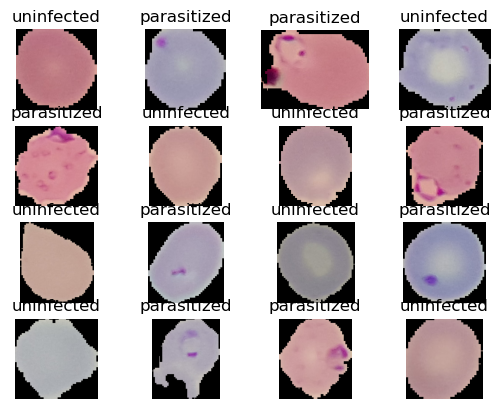

In [8]:
for i, (image, label) in enumerate(train_dataset.take(16)):
  ax = plt.subplot(4, 4, i + 1)
  
  plt.imshow(image)
  plt.title(dataset_info.features['label'].int2str(label))
  plt.axis('off')

# Data preprocessing

In [9]:
IM_SIZE=224
def resiz_rescale(image,label):
    return tf.image.resize(image,(IM_SIZE,IM_SIZE))/255.0, label
    

In [10]:
train_dataset=train_dataset.map(resiz_rescale)
val_dataset=val_dataset.map(resiz_rescale)
test_dataset=test_dataset.map(resiz_rescale)

In [11]:
train_dataset=train_dataset.shuffle(buffer_size=8,reshuffle_each_iteration=True).batch(32).prefetch(tf.data.AUTOTUNE)
val_dataset=val_dataset.shuffle(buffer_size=8,reshuffle_each_iteration=True).batch(32).prefetch(tf.data.AUTOTUNE)

# Hyperparameter Tuning

In [11]:
LOG_DIR="./logs"
tensorboard_callback = TensorBoard(log_dir=LOG_DIR)

In [12]:
es_callback=EarlyStopping(
    monitor='val_loss',patience=3, verbose=1,restore_best_weights=True,
)

In [13]:
IM_SIZE = 224
def model_tune(hparams):
  lenet_model = tf.keras.Sequential([
    InputLayer(input_shape = (IM_SIZE, IM_SIZE, 3)),

    Conv2D(filters = 6, kernel_size = 3, strides=1, padding='valid',
          activation = 'relu',),
    BatchNormalization(),
    MaxPool2D (pool_size = 2, strides= 2),
    Dropout(rate = hparams[HP_DROPOUT]),

    Conv2D(filters = 16, kernel_size = 3, strides=1, padding='valid',
          activation = 'relu', ),
    BatchNormalization(),
    MaxPool2D (pool_size = 2, strides= 2),

    Flatten(),
    
    Dense( hparams[HP_NUM_UNITS_1], activation = "relu", ),
    BatchNormalization(),
    Dropout(rate = hparams[HP_DROPOUT]),
    
    Dense(hparams[HP_NUM_UNITS_2], activation = "relu", ),
    BatchNormalization(),

    Dense(1, activation = "sigmoid"),
  ])

  lenet_model.compile(
        optimizer= Adam(learning_rate = hparams[HP_LEARNING_RATE]),
        loss='binary_crossentropy',
        metrics=['accuracy'],
    )

  lenet_model.fit(train_dataset, validation_data=val_dataset ,epochs=20,callbacks=[tensorboard_callback,es_callback])
  _, accuracy = lenet_model.evaluate(val_dataset)
  return accuracy

In [26]:
HP_NUM_UNITS_1 = hp.HParam('num_units_1', hp.Discrete([32,64,128]))
HP_NUM_UNITS_2 = hp.HParam('num_units_2', hp.Discrete([16,32]))
HP_DROPOUT = hp.HParam('dropout_rate', hp.Discrete([0.1,0.2]))
HP_LEARNING_RATE = hp.HParam('learning_rate', hp.Discrete([1e-4, 1e-3]))



In [18]:
run_number = 0
for num_units_1 in HP_NUM_UNITS_1.domain.values:
  for num_units_2 in HP_NUM_UNITS_2.domain.values:
    for dropout_rate in HP_DROPOUT.domain.values:
        for learning_rate in HP_LEARNING_RATE.domain.values:

          hparams = {
            
              HP_NUM_UNITS_1: num_units_1,
              HP_NUM_UNITS_2: num_units_2,
              HP_DROPOUT: dropout_rate,
              HP_LEARNING_RATE: learning_rate,
              
          }
          file_writer = tf.summary.create_file_writer('logs/hparams-' + str(run_number))

          with file_writer.as_default():
              hp.hparams(hparams)
              accuracy = model_tune(hparams)
              tf.summary.scalar('accuracy', accuracy, step = 0)
          print("For the run {}, hparams num_units_1:{}, num_units_2:{}, dropout:{}, learning_rate:{}".format(run_number, hparams[HP_NUM_UNITS_1],
                                                   hparams[HP_NUM_UNITS_2],hparams[HP_DROPOUT],
                                                   hparams[HP_LEARNING_RATE]))
          run_number += 1

Epoch 1/20


2024-04-05 16:00:41.008293: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_2/dropout_4/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


603/603 [==============================] - 28s 44ms/step - loss: 0.6076 - accuracy: 0.6785 - val_loss: 0.6989 - val_accuracy: 0.5747
Epoch 2/20
603/603 [==============================] - 27s 44ms/step - loss: 0.5110 - accuracy: 0.7474 - val_loss: 0.7176 - val_accuracy: 0.6574
Epoch 3/20
603/603 [==============================] - 26s 43ms/step - loss: 0.3980 - accuracy: 0.8258 - val_loss: 0.7526 - val_accuracy: 0.6868
Epoch 4/20
603/603 [==============================] - 26s 43ms/step - loss: 0.3176 - accuracy: 0.8701 - val_loss: 0.7057 - val_accuracy: 0.7148
Epoch 4: early stopping
173/173 [==============================] - 3s 12ms/step - loss: 0.6985 - accuracy: 0.5754
For the run 0, hparams num_units_1:32, num_units_2:16, dropout:0.1, learning_rate:0.0001
Epoch 1/20


2024-04-05 16:02:30.976731: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_3/dropout_6/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


603/603 [==============================] - 28s 43ms/step - loss: 0.3581 - accuracy: 0.8571 - val_loss: 0.2531 - val_accuracy: 0.9116
Epoch 2/20
603/603 [==============================] - 26s 43ms/step - loss: 0.2180 - accuracy: 0.9243 - val_loss: 0.2095 - val_accuracy: 0.9274
Epoch 3/20
603/603 [==============================] - 26s 43ms/step - loss: 0.2001 - accuracy: 0.9291 - val_loss: 0.2121 - val_accuracy: 0.9271
Epoch 4/20
603/603 [==============================] - 26s 43ms/step - loss: 0.1792 - accuracy: 0.9374 - val_loss: 0.1895 - val_accuracy: 0.9341
Epoch 5/20
603/603 [==============================] - 26s 43ms/step - loss: 0.1663 - accuracy: 0.9411 - val_loss: 0.1932 - val_accuracy: 0.9316
Epoch 6/20
603/603 [==============================] - 27s 44ms/step - loss: 0.1425 - accuracy: 0.9500 - val_loss: 0.1874 - val_accuracy: 0.9401
Epoch 7/20
603/603 [==============================] - 27s 44ms/step - loss: 0.1265 - accuracy: 0.9548 - val_loss: 0.2198 - val_accuracy: 0.9323
Epo

2024-04-05 16:06:32.770443: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_4/dropout_8/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


603/603 [==============================] - 28s 44ms/step - loss: 0.5619 - accuracy: 0.7138 - val_loss: 1.5296 - val_accuracy: 0.5513
Epoch 2/20
603/603 [==============================] - 27s 44ms/step - loss: 0.3556 - accuracy: 0.8604 - val_loss: 1.0150 - val_accuracy: 0.7124
Epoch 3/20
603/603 [==============================] - 27s 44ms/step - loss: 0.2986 - accuracy: 0.8874 - val_loss: 0.9750 - val_accuracy: 0.7436
Epoch 4/20
603/603 [==============================] - 27s 44ms/step - loss: 0.2770 - accuracy: 0.8966 - val_loss: 1.0555 - val_accuracy: 0.7177
Epoch 5/20
603/603 [==============================] - 27s 44ms/step - loss: 0.2518 - accuracy: 0.9049 - val_loss: 0.8114 - val_accuracy: 0.7926
Epoch 6/20
603/603 [==============================] - 27s 45ms/step - loss: 0.2335 - accuracy: 0.9139 - val_loss: 0.6630 - val_accuracy: 0.8409
Epoch 7/20
603/603 [==============================] - 27s 44ms/step - loss: 0.2208 - accuracy: 0.9190 - val_loss: 0.6118 - val_accuracy: 0.8439
Epo

2024-04-05 16:13:19.669694: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_5/dropout_10/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


603/603 [==============================] - 28s 44ms/step - loss: 0.5641 - accuracy: 0.7135 - val_loss: 2.2201 - val_accuracy: 0.5170
Epoch 2/20
603/603 [==============================] - 27s 44ms/step - loss: 0.2704 - accuracy: 0.8996 - val_loss: 0.3413 - val_accuracy: 0.8594
Epoch 3/20
603/603 [==============================] - 27s 45ms/step - loss: 0.2280 - accuracy: 0.9208 - val_loss: 0.3771 - val_accuracy: 0.8692
Epoch 4/20
603/603 [==============================] - 27s 44ms/step - loss: 0.2160 - accuracy: 0.9266 - val_loss: 1.3144 - val_accuracy: 0.8719
Epoch 5/20
603/603 [==============================] - 27s 45ms/step - loss: 0.1866 - accuracy: 0.9351 - val_loss: 0.3866 - val_accuracy: 0.8664
Epoch 5: early stopping
173/173 [==============================] - 4s 13ms/step - loss: 0.3404 - accuracy: 0.8603
For the run 3, hparams num_units_1:32, num_units_2:16, dropout:0.2, learning_rate:0.001
Epoch 1/20


2024-04-05 16:15:38.874749: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_6/dropout_12/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


603/603 [==============================] - 28s 44ms/step - loss: 0.6392 - accuracy: 0.6359 - val_loss: 0.7008 - val_accuracy: 0.6119
Epoch 2/20
603/603 [==============================] - 26s 44ms/step - loss: 0.5561 - accuracy: 0.7124 - val_loss: 0.6659 - val_accuracy: 0.6545
Epoch 3/20
603/603 [==============================] - 27s 44ms/step - loss: 0.4745 - accuracy: 0.7742 - val_loss: 0.8214 - val_accuracy: 0.6209
Epoch 4/20
603/603 [==============================] - 26s 44ms/step - loss: 0.3564 - accuracy: 0.8466 - val_loss: 0.9290 - val_accuracy: 0.6538
Epoch 5/20
603/603 [==============================] - 26s 44ms/step - loss: 0.2763 - accuracy: 0.8903 - val_loss: 0.8803 - val_accuracy: 0.6605
Epoch 5: early stopping
173/173 [==============================] - 4s 13ms/step - loss: 0.6651 - accuracy: 0.6549
For the run 4, hparams num_units_1:32, num_units_2:32, dropout:0.1, learning_rate:0.0001
Epoch 1/20


2024-04-05 16:17:56.404118: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_7/dropout_14/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


603/603 [==============================] - 27s 42ms/step - loss: 0.3320 - accuracy: 0.8643 - val_loss: 0.6404 - val_accuracy: 0.7338
Epoch 2/20
603/603 [==============================] - 25s 41ms/step - loss: 0.2532 - accuracy: 0.9055 - val_loss: 0.2695 - val_accuracy: 0.9162
Epoch 3/20
603/603 [==============================] - 25s 42ms/step - loss: 0.2048 - accuracy: 0.9293 - val_loss: 0.2673 - val_accuracy: 0.9105
Epoch 4/20
603/603 [==============================] - 25s 41ms/step - loss: 0.1744 - accuracy: 0.9382 - val_loss: 0.4953 - val_accuracy: 0.8946
Epoch 5/20
603/603 [==============================] - 25s 42ms/step - loss: 0.1468 - accuracy: 0.9480 - val_loss: 0.3466 - val_accuracy: 0.8815
Epoch 6/20
603/603 [==============================] - 25s 42ms/step - loss: 0.1275 - accuracy: 0.9532 - val_loss: 0.4737 - val_accuracy: 0.8285
Epoch 6: early stopping
173/173 [==============================] - 4s 13ms/step - loss: 0.2675 - accuracy: 0.9104
For the run 5, hparams num_units_

2024-04-05 16:20:32.607550: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_8/dropout_16/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


603/603 [==============================] - 29s 45ms/step - loss: 0.6067 - accuracy: 0.6760 - val_loss: 1.7782 - val_accuracy: 0.5790
Epoch 2/20
603/603 [==============================] - 27s 45ms/step - loss: 0.4729 - accuracy: 0.7772 - val_loss: 1.6904 - val_accuracy: 0.5819
Epoch 3/20
603/603 [==============================] - 27s 44ms/step - loss: 0.3422 - accuracy: 0.8619 - val_loss: 1.2799 - val_accuracy: 0.6634
Epoch 4/20
603/603 [==============================] - 27s 44ms/step - loss: 0.2913 - accuracy: 0.8907 - val_loss: 2.6411 - val_accuracy: 0.6384
Epoch 5/20
603/603 [==============================] - 27s 44ms/step - loss: 0.2578 - accuracy: 0.9046 - val_loss: 4.2196 - val_accuracy: 0.7001
Epoch 6/20
603/603 [==============================] - 27s 44ms/step - loss: 0.2305 - accuracy: 0.9170 - val_loss: 5.1914 - val_accuracy: 0.7106
Epoch 6: early stopping
173/173 [==============================] - 4s 13ms/step - loss: 1.2697 - accuracy: 0.6638
For the run 6, hparams num_units_

2024-04-05 16:23:19.116435: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_9/dropout_18/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


603/603 [==============================] - 28s 44ms/step - loss: 0.4731 - accuracy: 0.7716 - val_loss: 2.5796 - val_accuracy: 0.5837
Epoch 2/20
603/603 [==============================] - 27s 44ms/step - loss: 0.2318 - accuracy: 0.9179 - val_loss: 0.3553 - val_accuracy: 0.8672
Epoch 3/20
603/603 [==============================] - 26s 44ms/step - loss: 0.1967 - accuracy: 0.9337 - val_loss: 0.3661 - val_accuracy: 0.8862
Epoch 4/20
603/603 [==============================] - 26s 44ms/step - loss: 0.1720 - accuracy: 0.9423 - val_loss: 0.3223 - val_accuracy: 0.8826
Epoch 5/20
603/603 [==============================] - 27s 44ms/step - loss: 0.1591 - accuracy: 0.9450 - val_loss: 0.2885 - val_accuracy: 0.8975
Epoch 6/20
603/603 [==============================] - 27s 44ms/step - loss: 0.1373 - accuracy: 0.9534 - val_loss: 0.2893 - val_accuracy: 0.8957
Epoch 7/20
603/603 [==============================] - 26s 44ms/step - loss: 0.1246 - accuracy: 0.9551 - val_loss: 0.5061 - val_accuracy: 0.8806
Epo

2024-04-05 16:26:56.840940: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_10/dropout_20/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


603/603 [==============================] - 29s 45ms/step - loss: 0.6097 - accuracy: 0.6696 - val_loss: 0.6726 - val_accuracy: 0.6540
Epoch 2/20
603/603 [==============================] - 27s 45ms/step - loss: 0.5329 - accuracy: 0.7293 - val_loss: 0.9701 - val_accuracy: 0.6004
Epoch 3/20
603/603 [==============================] - 27s 45ms/step - loss: 0.4417 - accuracy: 0.7961 - val_loss: 1.2021 - val_accuracy: 0.5794
Epoch 4/20
603/603 [==============================] - 27s 45ms/step - loss: 0.3537 - accuracy: 0.8490 - val_loss: 0.9567 - val_accuracy: 0.6322
Epoch 4: early stopping
173/173 [==============================] - 4s 13ms/step - loss: 0.6715 - accuracy: 0.6538
For the run 8, hparams num_units_1:64, num_units_2:16, dropout:0.1, learning_rate:0.0001
Epoch 1/20


2024-04-05 16:28:51.341891: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_11/dropout_22/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


603/603 [==============================] - 29s 45ms/step - loss: 0.3864 - accuracy: 0.8290 - val_loss: 0.4197 - val_accuracy: 0.8312
Epoch 2/20
603/603 [==============================] - 27s 45ms/step - loss: 0.2288 - accuracy: 0.9177 - val_loss: 2.2991 - val_accuracy: 0.5961
Epoch 3/20
603/603 [==============================] - 27s 45ms/step - loss: 0.1964 - accuracy: 0.9320 - val_loss: 0.1754 - val_accuracy: 0.9412
Epoch 4/20
603/603 [==============================] - 27s 45ms/step - loss: 0.1651 - accuracy: 0.9406 - val_loss: 0.2769 - val_accuracy: 0.9113
Epoch 5/20
603/603 [==============================] - 27s 45ms/step - loss: 0.1437 - accuracy: 0.9488 - val_loss: 0.2576 - val_accuracy: 0.9225
Epoch 6/20
603/603 [==============================] - 27s 45ms/step - loss: 0.1276 - accuracy: 0.9539 - val_loss: 0.2016 - val_accuracy: 0.9372
Epoch 6: early stopping
173/173 [==============================] - 4s 13ms/step - loss: 0.1738 - accuracy: 0.9418
For the run 9, hparams num_units_

2024-04-05 16:31:39.416689: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_12/dropout_24/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


603/603 [==============================] - 29s 45ms/step - loss: 0.6100 - accuracy: 0.6752 - val_loss: 0.6377 - val_accuracy: 0.6358
Epoch 2/20
603/603 [==============================] - 27s 45ms/step - loss: 0.5599 - accuracy: 0.7187 - val_loss: 1.0128 - val_accuracy: 0.5543
Epoch 3/20
603/603 [==============================] - 27s 45ms/step - loss: 0.5155 - accuracy: 0.7460 - val_loss: 3.8275 - val_accuracy: 0.5467
Epoch 4/20
603/603 [==============================] - 28s 46ms/step - loss: 0.4588 - accuracy: 0.7871 - val_loss: 30.0729 - val_accuracy: 0.5250
Epoch 4: early stopping
173/173 [==============================] - 4s 13ms/step - loss: 0.6377 - accuracy: 0.6362
For the run 10, hparams num_units_1:64, num_units_2:16, dropout:0.2, learning_rate:0.0001
Epoch 1/20


2024-04-05 16:33:34.083247: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_13/dropout_26/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


603/603 [==============================] - 29s 45ms/step - loss: 0.6112 - accuracy: 0.6769 - val_loss: 1.1905 - val_accuracy: 0.5184
Epoch 2/20
603/603 [==============================] - 27s 45ms/step - loss: 0.4144 - accuracy: 0.8094 - val_loss: 1.6306 - val_accuracy: 0.6218
Epoch 3/20
603/603 [==============================] - 28s 46ms/step - loss: 0.2583 - accuracy: 0.9009 - val_loss: 0.4547 - val_accuracy: 0.8494
Epoch 4/20
603/603 [==============================] - 27s 45ms/step - loss: 0.2266 - accuracy: 0.9148 - val_loss: 0.2833 - val_accuracy: 0.9129
Epoch 5/20
603/603 [==============================] - 27s 45ms/step - loss: 0.1923 - accuracy: 0.9310 - val_loss: 0.2407 - val_accuracy: 0.9149
Epoch 6/20
603/603 [==============================] - 27s 45ms/step - loss: 0.1757 - accuracy: 0.9368 - val_loss: 0.2516 - val_accuracy: 0.9212
Epoch 7/20
603/603 [==============================] - 27s 45ms/step - loss: 0.1552 - accuracy: 0.9441 - val_loss: 0.2962 - val_accuracy: 0.9160
Epo

2024-04-05 16:37:17.888360: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_14/dropout_28/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


603/603 [==============================] - 29s 45ms/step - loss: 0.6421 - accuracy: 0.6495 - val_loss: 0.8424 - val_accuracy: 0.5395
Epoch 2/20
603/603 [==============================] - 27s 45ms/step - loss: 0.5318 - accuracy: 0.7319 - val_loss: 1.2991 - val_accuracy: 0.5983
Epoch 3/20
603/603 [==============================] - 27s 45ms/step - loss: 0.3873 - accuracy: 0.8274 - val_loss: 1.7879 - val_accuracy: 0.6570
Epoch 4/20
603/603 [==============================] - 27s 45ms/step - loss: 0.2927 - accuracy: 0.8829 - val_loss: 1.9967 - val_accuracy: 0.6766
Epoch 4: early stopping
173/173 [==============================] - 4s 13ms/step - loss: 0.8436 - accuracy: 0.5393
For the run 12, hparams num_units_1:64, num_units_2:32, dropout:0.1, learning_rate:0.0001
Epoch 1/20


2024-04-05 16:39:12.119368: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_15/dropout_30/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


603/603 [==============================] - 29s 46ms/step - loss: 0.5240 - accuracy: 0.7365 - val_loss: 1.7114 - val_accuracy: 0.5959
Epoch 2/20
603/603 [==============================] - 28s 46ms/step - loss: 0.3252 - accuracy: 0.8667 - val_loss: 0.2975 - val_accuracy: 0.8873
Epoch 3/20
603/603 [==============================] - 27s 45ms/step - loss: 0.2346 - accuracy: 0.9148 - val_loss: 0.2709 - val_accuracy: 0.9151
Epoch 4/20
603/603 [==============================] - 27s 45ms/step - loss: 0.2007 - accuracy: 0.9271 - val_loss: 0.2364 - val_accuracy: 0.9294
Epoch 5/20
603/603 [==============================] - 27s 45ms/step - loss: 0.1892 - accuracy: 0.9305 - val_loss: 0.3001 - val_accuracy: 0.9163
Epoch 6/20
603/603 [==============================] - 27s 45ms/step - loss: 0.1649 - accuracy: 0.9424 - val_loss: 0.2646 - val_accuracy: 0.9209
Epoch 7/20
603/603 [==============================] - 27s 45ms/step - loss: 0.1492 - accuracy: 0.9449 - val_loss: 0.4377 - val_accuracy: 0.9182
Epo

2024-04-05 16:42:29.056770: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_16/dropout_32/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


603/603 [==============================] - 29s 45ms/step - loss: 0.6153 - accuracy: 0.6722 - val_loss: 0.6615 - val_accuracy: 0.6257
Epoch 2/20
603/603 [==============================] - 27s 45ms/step - loss: 0.5210 - accuracy: 0.7448 - val_loss: 0.7763 - val_accuracy: 0.6516
Epoch 3/20
603/603 [==============================] - 27s 45ms/step - loss: 0.4322 - accuracy: 0.8022 - val_loss: 1.1347 - val_accuracy: 0.6320
Epoch 4/20
603/603 [==============================] - 27s 45ms/step - loss: 0.3437 - accuracy: 0.8539 - val_loss: 1.4581 - val_accuracy: 0.6474
Epoch 4: early stopping
173/173 [==============================] - 4s 13ms/step - loss: 0.6627 - accuracy: 0.6248
For the run 14, hparams num_units_1:64, num_units_2:32, dropout:0.2, learning_rate:0.0001
Epoch 1/20


2024-04-05 16:44:22.256432: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_17/dropout_34/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


603/603 [==============================] - 29s 45ms/step - loss: 0.4766 - accuracy: 0.7703 - val_loss: 3.1558 - val_accuracy: 0.6619
Epoch 2/20
603/603 [==============================] - 27s 45ms/step - loss: 0.2559 - accuracy: 0.9044 - val_loss: 0.4813 - val_accuracy: 0.8532
Epoch 3/20
603/603 [==============================] - 27s 45ms/step - loss: 0.2109 - accuracy: 0.9220 - val_loss: 0.4698 - val_accuracy: 0.9140
Epoch 4/20
603/603 [==============================] - 27s 45ms/step - loss: 0.1904 - accuracy: 0.9319 - val_loss: 0.5867 - val_accuracy: 0.8234
Epoch 5/20
603/603 [==============================] - 27s 45ms/step - loss: 0.1785 - accuracy: 0.9358 - val_loss: 0.2150 - val_accuracy: 0.9220
Epoch 6/20
603/603 [==============================] - 27s 45ms/step - loss: 0.1656 - accuracy: 0.9389 - val_loss: 1.4123 - val_accuracy: 0.7144
Epoch 7/20
603/603 [==============================] - 27s 44ms/step - loss: 0.1499 - accuracy: 0.9464 - val_loss: 0.2956 - val_accuracy: 0.8880
Epo

2024-04-05 16:48:03.834659: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_18/dropout_36/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


603/603 [==============================] - 30s 46ms/step - loss: 0.6109 - accuracy: 0.6750 - val_loss: 0.9199 - val_accuracy: 0.5540
Epoch 2/20
603/603 [==============================] - 28s 46ms/step - loss: 0.5228 - accuracy: 0.7427 - val_loss: 2.0506 - val_accuracy: 0.5358
Epoch 3/20
603/603 [==============================] - 28s 46ms/step - loss: 0.4404 - accuracy: 0.7941 - val_loss: 3.1982 - val_accuracy: 0.5382
Epoch 4/20
603/603 [==============================] - 28s 46ms/step - loss: 0.3414 - accuracy: 0.8580 - val_loss: 4.5233 - val_accuracy: 0.5436
Epoch 4: early stopping
173/173 [==============================] - 4s 13ms/step - loss: 0.9180 - accuracy: 0.5558
For the run 16, hparams num_units_1:128, num_units_2:16, dropout:0.1, learning_rate:0.0001
Epoch 1/20


2024-04-05 16:50:00.495198: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_19/dropout_38/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


603/603 [==============================] - 29s 46ms/step - loss: 0.5545 - accuracy: 0.7179 - val_loss: 3.9328 - val_accuracy: 0.5124
Epoch 2/20
603/603 [==============================] - 28s 46ms/step - loss: 0.2498 - accuracy: 0.9081 - val_loss: 0.2991 - val_accuracy: 0.8980
Epoch 3/20
603/603 [==============================] - 28s 46ms/step - loss: 0.1958 - accuracy: 0.9301 - val_loss: 0.2065 - val_accuracy: 0.9291
Epoch 4/20
603/603 [==============================] - 28s 46ms/step - loss: 0.1621 - accuracy: 0.9409 - val_loss: 0.2634 - val_accuracy: 0.9176
Epoch 5/20
603/603 [==============================] - 28s 46ms/step - loss: 0.1378 - accuracy: 0.9491 - val_loss: 0.2644 - val_accuracy: 0.9147
Epoch 6/20
603/603 [==============================] - 28s 46ms/step - loss: 0.1212 - accuracy: 0.9566 - val_loss: 1.4638 - val_accuracy: 0.7198
Epoch 6: early stopping
173/173 [==============================] - 4s 13ms/step - loss: 0.2069 - accuracy: 0.9292
For the run 17, hparams num_units

2024-04-05 16:52:52.186719: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_20/dropout_40/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


603/603 [==============================] - 29s 45ms/step - loss: 0.6264 - accuracy: 0.6524 - val_loss: 0.6438 - val_accuracy: 0.6351
Epoch 2/20
603/603 [==============================] - 27s 45ms/step - loss: 0.5755 - accuracy: 0.6964 - val_loss: 0.6336 - val_accuracy: 0.6587
Epoch 3/20
603/603 [==============================] - 27s 45ms/step - loss: 0.5423 - accuracy: 0.7272 - val_loss: 0.8241 - val_accuracy: 0.5776
Epoch 4/20
603/603 [==============================] - 27s 45ms/step - loss: 0.5078 - accuracy: 0.7524 - val_loss: 0.9722 - val_accuracy: 0.5767
Epoch 5/20
603/603 [==============================] - 27s 45ms/step - loss: 0.4677 - accuracy: 0.7823 - val_loss: 1.2283 - val_accuracy: 0.5788
Epoch 5: early stopping
173/173 [==============================] - 4s 13ms/step - loss: 0.6353 - accuracy: 0.6574
For the run 18, hparams num_units_1:128, num_units_2:16, dropout:0.2, learning_rate:0.0001
Epoch 1/20


2024-04-05 16:55:14.178262: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_21/dropout_42/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


603/603 [==============================] - 30s 46ms/step - loss: 0.5576 - accuracy: 0.7178 - val_loss: 0.7236 - val_accuracy: 0.7204
Epoch 2/20
603/603 [==============================] - 28s 46ms/step - loss: 0.2782 - accuracy: 0.8948 - val_loss: 0.6486 - val_accuracy: 0.8046
Epoch 3/20
603/603 [==============================] - 28s 46ms/step - loss: 0.2300 - accuracy: 0.9153 - val_loss: 0.3014 - val_accuracy: 0.8871
Epoch 4/20
603/603 [==============================] - 28s 46ms/step - loss: 0.2295 - accuracy: 0.9159 - val_loss: 0.5031 - val_accuracy: 0.9205
Epoch 5/20
603/603 [==============================] - 28s 46ms/step - loss: 0.2221 - accuracy: 0.9155 - val_loss: 0.4296 - val_accuracy: 0.8563
Epoch 6/20
603/603 [==============================] - 28s 46ms/step - loss: 0.1900 - accuracy: 0.9318 - val_loss: 0.3421 - val_accuracy: 0.9024
Epoch 6: early stopping
173/173 [==============================] - 4s 13ms/step - loss: 0.3022 - accuracy: 0.8868
For the run 19, hparams num_units

2024-04-05 16:58:06.506632: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_22/dropout_44/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


603/603 [==============================] - 29s 46ms/step - loss: 0.5596 - accuracy: 0.7162 - val_loss: 0.7805 - val_accuracy: 0.6240
Epoch 2/20
603/603 [==============================] - 28s 46ms/step - loss: 0.3983 - accuracy: 0.8210 - val_loss: 0.8107 - val_accuracy: 0.6810
Epoch 3/20
603/603 [==============================] - 28s 46ms/step - loss: 0.2910 - accuracy: 0.8803 - val_loss: 0.9263 - val_accuracy: 0.7022
Epoch 4/20
603/603 [==============================] - 28s 46ms/step - loss: 0.2298 - accuracy: 0.9114 - val_loss: 0.9802 - val_accuracy: 0.7289
Epoch 4: early stopping
173/173 [==============================] - 4s 13ms/step - loss: 0.7813 - accuracy: 0.6228
For the run 20, hparams num_units_1:128, num_units_2:32, dropout:0.1, learning_rate:0.0001
Epoch 1/20


2024-04-05 17:00:02.645393: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_23/dropout_46/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


603/603 [==============================] - 29s 46ms/step - loss: 0.3636 - accuracy: 0.8449 - val_loss: 0.6164 - val_accuracy: 0.7616
Epoch 2/20
603/603 [==============================] - 28s 46ms/step - loss: 0.2481 - accuracy: 0.9029 - val_loss: 0.2050 - val_accuracy: 0.9307
Epoch 3/20
603/603 [==============================] - 28s 46ms/step - loss: 0.1953 - accuracy: 0.9276 - val_loss: 0.3062 - val_accuracy: 0.8940
Epoch 4/20
603/603 [==============================] - 28s 46ms/step - loss: 0.1732 - accuracy: 0.9380 - val_loss: 0.4188 - val_accuracy: 0.8559
Epoch 5/20
603/603 [==============================] - 28s 46ms/step - loss: 0.1685 - accuracy: 0.9387 - val_loss: 0.4000 - val_accuracy: 0.8942
Epoch 5: early stopping
173/173 [==============================] - 4s 13ms/step - loss: 0.2050 - accuracy: 0.9310
For the run 21, hparams num_units_1:128, num_units_2:32, dropout:0.1, learning_rate:0.001
Epoch 1/20


2024-04-05 17:02:26.609416: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_24/dropout_48/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


603/603 [==============================] - 29s 46ms/step - loss: 0.6234 - accuracy: 0.6681 - val_loss: 0.8209 - val_accuracy: 0.5540
Epoch 2/20
603/603 [==============================] - 28s 46ms/step - loss: 0.5144 - accuracy: 0.7461 - val_loss: 1.2919 - val_accuracy: 0.5444
Epoch 3/20
603/603 [==============================] - 28s 46ms/step - loss: 0.3444 - accuracy: 0.8557 - val_loss: 1.6431 - val_accuracy: 0.6090
Epoch 4/20
603/603 [==============================] - 28s 46ms/step - loss: 0.2522 - accuracy: 0.9049 - val_loss: 1.5632 - val_accuracy: 0.6874
Epoch 4: early stopping
173/173 [==============================] - 4s 13ms/step - loss: 0.8194 - accuracy: 0.5553
For the run 22, hparams num_units_1:128, num_units_2:32, dropout:0.2, learning_rate:0.0001
Epoch 1/20


2024-04-05 17:04:23.278797: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_25/dropout_50/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


603/603 [==============================] - 30s 47ms/step - loss: 0.5283 - accuracy: 0.7389 - val_loss: 1.6461 - val_accuracy: 0.6013
Epoch 2/20
603/603 [==============================] - 28s 46ms/step - loss: 0.3156 - accuracy: 0.8702 - val_loss: 0.7549 - val_accuracy: 0.6627
Epoch 3/20
603/603 [==============================] - 28s 47ms/step - loss: 0.2557 - accuracy: 0.9029 - val_loss: 13.9719 - val_accuracy: 0.7884
Epoch 4/20
603/603 [==============================] - 28s 46ms/step - loss: 0.2392 - accuracy: 0.9086 - val_loss: 51.8989 - val_accuracy: 0.7480
Epoch 5/20
603/603 [==============================] - 28s 46ms/step - loss: 0.2071 - accuracy: 0.9268 - val_loss: 16.2319 - val_accuracy: 0.8674
Epoch 5: early stopping
173/173 [==============================] - 4s 13ms/step - loss: 0.7286 - accuracy: 0.6639
For the run 23, hparams num_units_1:128, num_units_2:32, dropout:0.2, learning_rate:0.001


# Model Evaluation

In [12]:
%load_ext tensorboard

In [46]:
%tensorboard --logdir=./logs

Reusing TensorBoard on port 6006 (pid 5648), started 1:15:04 ago. (Use '!kill 5648' to kill it.)

In [ ]:
 #  rm -rf ./logs/ 

# Final Model Building And Training

In [37]:
hp= {
            
              'HP_NUM_UNITS_1': 64,
              'HP_NUM_UNITS_2': 16,
              'HP_DROPOUT': 0.1,
              'HP_LEARNING_RATE': 0.001,
              
          }

In [38]:
IM_SIZE = 224

final_model = tf.keras.Sequential([
      InputLayer(input_shape = (IM_SIZE, IM_SIZE, 3)),

      Conv2D(filters = 6, kernel_size = 3, strides=1, padding='valid',
            activation = 'relu',),
      BatchNormalization(),
      MaxPool2D (pool_size = 2, strides= 2),
      Dropout(rate = hp['HP_DROPOUT']),

      Conv2D(filters = 16, kernel_size = 3, strides=1, padding='valid',
            activation = 'relu', ),
      BatchNormalization(),
      MaxPool2D (pool_size = 2, strides= 2),

      Flatten(),

      Dense( hp['HP_NUM_UNITS_1'], activation = "relu", ),
      BatchNormalization(),
      Dropout(rate = hp['HP_DROPOUT']),

      Dense(hp['HP_NUM_UNITS_2'], activation = "relu", ),
      BatchNormalization(),

      Dense(1, activation = "sigmoid"),
      ])
final_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 222, 222, 6)       168       
                                                                 
 batch_normalization_8 (Bat  (None, 222, 222, 6)       24        
 chNormalization)                                                
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 111, 111, 6)       0         
 g2D)                                                            
                                                                 
 dropout_4 (Dropout)         (None, 111, 111, 6)       0         
                                                                 
 conv2d_5 (Conv2D)           (None, 109, 109, 16)      880       
                                                                 
 batch_normalization_9 (Bat  (None, 109, 109, 16)     

In [39]:
final_model.compile(
      optimizer= Adam(learning_rate = hparams[HP_LEARNING_RATE]),
      loss='binary_crossentropy',
      metrics=['accuracy'],
)

In [40]:
final_model.fit(train_dataset, validation_data=val_dataset ,epochs=20,)

Epoch 1/20


2024-04-05 18:41:52.571952: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_2/dropout_4/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


603/603 [==============================] - 27s 42ms/step - loss: 0.5344 - accuracy: 0.7312 - val_loss: 0.9106 - val_accuracy: 0.6244
Epoch 2/20
603/603 [==============================] - 25s 41ms/step - loss: 0.2483 - accuracy: 0.9090 - val_loss: 0.3419 - val_accuracy: 0.8851
Epoch 3/20
603/603 [==============================] - 25s 41ms/step - loss: 0.1924 - accuracy: 0.9305 - val_loss: 1.3361 - val_accuracy: 0.7503
Epoch 4/20
603/603 [==============================] - 25s 41ms/step - loss: 0.1710 - accuracy: 0.9392 - val_loss: 0.2999 - val_accuracy: 0.8982
Epoch 5/20
603/603 [==============================] - 25s 41ms/step - loss: 0.1502 - accuracy: 0.9463 - val_loss: 0.2819 - val_accuracy: 0.9209
Epoch 6/20
603/603 [==============================] - 25s 42ms/step - loss: 0.1346 - accuracy: 0.9506 - val_loss: 0.2195 - val_accuracy: 0.9314
Epoch 7/20
603/603 [==============================] - 25s 41ms/step - loss: 0.1136 - accuracy: 0.9585 - val_loss: 0.4925 - val_accuracy: 0.9198
Epo

In [41]:
final_model.save('model_1.h5') 

/home/harshal_kharkar/miniconda3/envs/one_for_all_lin/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


# Model Evaluation And Testing

In [42]:
final_model.evaluate(val_dataset)

173/173 [==============================] - 3s 13ms/step - loss: 0.3617 - accuracy: 0.9271


[0.36174800992012024, 0.9270550012588501]